<a href="https://colab.research.google.com/github/liu-res/Learning-to-Defer-with-Uncertainty/blob/main/LDU_demo_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The LDU_demo_notebook.ipynb can be used to apply the learning to defer with uncertainty (LDU) algorithm on variouse deep learning classification tasks, to reduce the risk or uncertainty in predictions. The LDU algorithm is described in publication at http://arxiv.org/abs/2108.07392

#### Example base model where the LDU algorithm will apply:

In [18]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import classification_report
import os
from google.colab import drive
drive.mount('drive')

class base_model_class(nn.Module):
    # predict if the MNIST digit is even or odd number
    def __init__(self):
        super(base_model_class, self).__init__()
        self.input_size = 784
        self.hidden_sizes = [128, 64]
        self.output_size = 2 #10, 
        self.l1 = nn.Linear(self.input_size, self.hidden_sizes[0])
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.l3 = nn.Linear(self.hidden_sizes[1], self.output_size)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.softmax(x, dim=1)


def trainer(model):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                    ])
    path_to_trainset = '/content/drive/MyDrive/demo_data/'
    if not os.path.exists(path_to_trainset):
        os.makedirs(path_to_trainset)

    dataset = datasets.MNIST(path_to_trainset, download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    device = 'cpu'
    epochs = 15
    loss_function = nn.NLLLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = epochs
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            # Training pass
            optimizer.zero_grad()
            output = model(images)
            # Convert MNIST labels to binary label indicating even or non-even(odd) digit
            labels = (labels%2==0).long()
            loss = loss_function(output, labels)
            # This is where the model learns by backpropagating
            loss.backward()
            # And optimizes its weights here
            optimizer.step()
            running_loss += loss.item()
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(trainloader)))
    print("\nTraining Time (in minutes) =", (time() - time0) / 60)
    return model


def validator(model, train=False, shuffle=False):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                    ])
    path_to_testset = '../demo_data/'
    if not os.path.exists(path_to_testset):
        os.makedirs(path_to_testset)

    dataset = datasets.MNIST(path_to_testset, download=True, train=train, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=shuffle)

    with torch.set_grad_enabled(False):
        label = []
        pred = []
        prob_NP = np.empty((0, model.output_size)).astype(float)  # 2-D array
        for images,labels in dataloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            out_mini = model(images)
            label.extend((labels%2==0).long().tolist())
            pred.extend(torch.max(out_mini.cpu().data, 1)[1].numpy().astype(int).tolist())
            prob_NP = np.concatenate((prob_NP, out_mini.cpu().data.numpy().astype(float)), axis=0)
            del images
            del out_mini
        print('\nClassification Report\n')
        print(classification_report(label, pred, target_names=['cls{}'.format(i) for i in range(model.output_size)]))
    return label, pred, prob_NP




Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


#### Generate deep ensembles:

In [21]:
#!~/.venvs/pt/bin/python
# -*- coding: utf-8 -*-
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import os
import math
from torch.nn.utils import clip_grad_norm_
import logging
import random
from scipy.stats import entropy
from google.colab import drive
drive.mount('drive')

class deep_ensemble_class:
    def __init__(self, n_ensembles, device):
        self.n_ensembles = n_ensembles
        self.device = device
        random.seed(47)
        self.list_seeds = random.sample(range(100), self.n_ensembles)
        self.path_ensemble = '/content/drive/MyDrive/ensemble_data/'

    def calculate_binned_entropy(self, i_preds, n_classes):
        # i_preds: predictions from deep ensembles for ith data point
        pks = []
        for i in range(n_classes):
            pks.append(float(len(i_preds[i_preds == i]) / self.n_ensembles))
        pks = np.array(pks)
        binned_entropy = entropy(pks)
        return binned_entropy

    def add_entropies(self, df_ens, pred_NP, n_classes, filter_zeros):
        logging.info('calculating uncertainty-related features...')
        if n_classes == 2:  # binary classification
            binned_entropy = []
            continuous_entropy = []
            col = ['ens{}cls1'.format(i) for i in range(self.n_ensembles)]
            df_probs = df_ens[col]
            for i in range(df_ens.shape[0]):
                preds = pred_NP[:, i]
                binned_entropy.append(self.calculate_binned_entropy(preds, n_classes))
                continuous_entropy.append(entropy(df_probs.loc[i]))
            if filter_zeros:
                if not all(v == 0 for v in binned_entropy):
                    df_ens['binned_entropy'] = binned_entropy
                else:
                    logging.info('binned entropy are all zero, will not included in LDU')

                if not all(v == 0 for v in continuous_entropy):
                    df_ens['continuous_entropy'] = continuous_entropy
                else:
                    logging.info('continuous entropy for binary class are all zero, will not included in LDU')
            else:
                df_ens['binned_entropy'] = binned_entropy
                df_ens['continuous_entropy'] = continuous_entropy

        else:  # multi-classificaton
            binned_entropy = []
            for i in range(df_ens.shape[0]):
                preds = pred_NP[:, i]
                binned_entropy.append(self.calculate_binned_entropy(preds, n_classes))

            if filter_zeros:
                if not all(v == 0 for v in binned_entropy):
                    df_ens['binned_entropy'] = binned_entropy
                else:
                    logging.info('binned entropy are all zero, will not included in LDU')
            else:
                df_ens['binned_entropy'] = binned_entropy

            for c in range(n_classes):
                continuous_entropy = []
                col = ['ens{}cls{}'.format(i, c) for i in range(self.n_ensembles)]
                df_probs = df_ens[col]
                for i in range(df_ens.shape[0]):
                    continuous_entropy.append(entropy(df_probs.loc[i]))
                if filter_zeros:
                    if not all(v == 0 for v in continuous_entropy):
                        df_ens['continuous_entropy_cls{}'.format(c)] = continuous_entropy
                    else:
                        logging.info('continuous entropy for class {} are all zero, will not included in LDU'.format(c))
                else:
                    df_ens['continuous_entropy_cls{}'.format(c)] = continuous_entropy
        return df_ens

    def ens_to_dataset(self, df_ens):
        x_NP = df_ens.drop(['label'], axis=1).to_numpy()
        labelNP = df_ens.label.to_numpy()
        x = torch.FloatTensor(x_NP.tolist())
        label = torch.LongTensor(labelNP.tolist())
        dataset = torch.utils.data.TensorDataset(x, label)
        return dataset

    def gether_ensembles(self, base_model_class, trainer, validator):
        df_train_ens = pd.DataFrame()
        df_test_ens = pd.DataFrame()
        train_pred = []
        test_pred = []
        compare_train_order = []
        compare_test_order = []

        for i in range(self.n_ensembles):
            # seed: control initialization state of the model
            seed = self.list_seeds[i]
            logging.info('ensemble {}, seed={} :'.format(i, seed))
            torch.cuda.empty_cache()
            torch.manual_seed(seed)
            model = base_model_class().to(self.device)
            model = trainer(model)
            train_label, train_pred_list, train_prob_NP = validator(model, train=True, shuffle=False)
            test_label, test_pred_list, test_prob_NP = validator(model, train=False, shuffle=False)
            if i != 0:
                if compare_train_order != train_label or compare_test_order != test_label:
                    logging.error('validation orders changed, need to turn off shuffle in validator')
                    return None, None, None, None

            compare_train_order = train_label
            compare_test_order = test_label

            train_pred.append(train_pred_list)
            test_pred.append(test_pred_list)
            for j in range(train_prob_NP.shape[1]):
                df_train_ens['ens{}cls{}'.format(i, j)] = train_prob_NP[:, j].tolist()
                df_test_ens['ens{}cls{}'.format(i, j)] = test_prob_NP[:, j].tolist()

        n_classes = train_prob_NP.shape[1]
        df_train_ens['label'] = train_label
        df_test_ens['label'] = test_label
        train_pred = np.array(train_pred)
        test_pred = np.array(test_pred)

        df_train_ens = self.add_entropies(df_train_ens, train_pred, n_classes, filter_zeros=True)
        df_test_ens = self.add_entropies(df_test_ens, test_pred, n_classes, filter_zeros=False)
        df_test_ens = df_test_ens[df_train_ens.columns.tolist()]

        if not os.path.exists(self.path_ensemble):
            os.makedirs(self.path_ensemble)
        df_train_ens.to_csv(os.path.join(self.path_ensemble, 'train_ensembles.csv'), index=False)
        df_test_ens.to_csv(os.path.join(self.path_ensemble, 'test_ensembles.csv'), index=False)
        pd.DataFrame([n_classes]).to_csv(os.path.join(self.path_ensemble, 'n_classes.csv'), index=False)

        return n_classes, df_train_ens.shape[1]-1, self.ens_to_dataset(df_train_ens), self.ens_to_dataset(df_test_ens)

    def load_ensemble(self):
        df_train_ens = pd.read_csv(os.path.join(self.path_ensemble, 'train_ensembles.csv'), sep=',')
        df_test_ens = pd.read_csv(os.path.join(self.path_ensemble, 'test_ensembles.csv'), sep=',')
        n_classes = pd.read_csv(os.path.join(self.path_ensemble, 'n_classes.csv'), sep=',')
        return int(n_classes.loc[0]), df_train_ens.shape[1] - 1, self.ens_to_dataset(df_train_ens), self.ens_to_dataset(df_test_ens)




Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


#### LDU network:

In [22]:
#!~/.venvs/pt/bin/python
# -*- coding: utf-8 -*-
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import os
import math
from torch.nn.utils import clip_grad_norm_
import logging
from tabulate import tabulate
from google.colab import drive
drive.mount('drive')


class ldu_model(nn.Module):

    def __init__(self, n_classes, input_size):
        super(ldu_model, self).__init__()
        self.n_classes = n_classes
        self.input_size = input_size
        self.hidden_size = 200
        self.output_size = n_classes + 1
        self.l1 = nn.Linear(self.input_size, self.hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.l3 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l3(x)
        x = F.softmax(x, dim=1)
        return x


class learning_ldu_class:

    def __init__(self, alpha_list, device='cpu', learning_rate=0.0009, epochs=20):
        self.device = device
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.alpha_list = alpha_list
        self.n_classes = None
        self.input_size = None
        self.seed = 47
        self.batch_size = 64
        self.defer_loss = nn.CrossEntropyLoss().to(self.device)
        self.pred_loss = nn.CrossEntropyLoss().to(self.device)

    def loss_function(self, outputs, labels, alpha):
        # Assume expert's predictions always correct and the expert cost is a constant
        batch_size = outputs.size()[0]
        rc = torch.tensor([self.n_classes] * batch_size)
        loss = self.defer_loss(outputs[range(batch_size)], rc) + alpha * self.pred_loss(outputs[range(batch_size)], labels)
        return loss

    def start_training(self, model, train_set, alpha):
        # model: the LDU model
        # alpha: the weight on defer option
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=self.batch_size, shuffle=True)
        model = model.to(self.device)
        # setup optimizer
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        # track training loss
        loss_epoch = np.zeros(self.epochs)
        # Training loop
        for e in range(self.epochs):
            running_loss = 0
            for x_var, y_var in train_loader:
                x_var = Variable(x_var)
                y_var = Variable(y_var)
                optimizer.zero_grad()
                out_mini = model(x_var)
                loss = self.loss_function(out_mini, y_var, alpha)
                # compute the gradient based on the loss
                loss.backward()
                # clip gradient to prevent underflow ( check by: out_mini.min())
                # clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
                optimizer.step()
                running_loss += loss.item()

            logging.info('epoch: {}, loss = {}'.format(e, running_loss/len(train_loader)))
            loss_epoch[e] = running_loss/len(train_loader)

        return model

    def predict(self, model, test_set):
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=self.batch_size, shuffle=False)
        with torch.set_grad_enabled(False):
            pred = []
            label = []
            for x_var, y_var in test_loader:
                out_mini = model(x_var)
                pred.extend(torch.max(out_mini.cpu().data, 1)[1].numpy().astype(int).tolist())
                label.extend(y_var.cpu().data.numpy().astype(float).tolist())

                del x_var
                del out_mini
            return pred, label

    def get_scores(self, test_y, pred_y):
        # test_y: list of true testing labels
        # pred_y: list of predicted labels
        # return f1, recall, precision
        if len(test_y) < 1:
            return [None, None, None, None]
        else:
            f1 = f1_score(test_y, pred_y, average='micro', zero_division=0)
            recall = recall_score(test_y, pred_y, average='micro', zero_division=0)
            precision = precision_score(test_y, pred_y, average='micro', zero_division=0)
            return [f1, recall, precision]

    def triage_scores(self, pred_y, test_y, n_classes):
        df = pd.DataFrame(
            {'true_y': test_y,
             'pred_y': pred_y
             })
        df_1 = df[df.pred_y != n_classes]
        df_2 = df[df.pred_y == n_classes]

        if not df_2.empty:
            df_expert = df_2.copy()
            df_expert['pred_y'] = df_expert['true_y']
            df_overall = df_1.append(df_expert)
            deferred_size = df_2.shape[0]
        else:
            df_overall = df_1.copy()
            deferred_size = 0

        deferred_ratio = deferred_size / float(df.shape[0])
        logging.info('deferred ratio = {}'.format(deferred_ratio))

        if not df_1.empty:
            size_for_automation = df_1.shape[0]
            model_scores = self.get_scores(df_1.true_y.tolist(), df_1.pred_y.tolist())
            logging.info(
                'Automated F1={}, recall={}, precision={}'.format(model_scores[0], model_scores[1], model_scores[2]))
        else:
            size_for_automation = 0
            model_scores = [None, None, None]

        overall_scores = self.get_scores(df_overall.true_y.tolist(), df_overall.pred_y.tolist())

        result = [deferred_ratio, deferred_size, size_for_automation]
        result.extend(overall_scores)
        result.extend(model_scores)

        return result

    def tune_ldu(self, ensemble_funcion):
        self.n_classes, self.input_size, train_set, test_set = ensemble_funcion()
        logging.info('num classes : {},  LDU input size : {}'.format(self.n_classes, self.input_size))

        df_score = pd.DataFrame(columns=['Alpha', 'Deferred_Ratio', 'Deferred_Size', 'Auto_Size', \
                                         'Overall_F1', 'Overall_Recall', 'Overall_Precision', \
                                         'Auto_F1 (micro)', 'Auto_Recall (micro)', 'Auto_Precision (micro)'],
                                dtype=object)
        i = 0
        for alpha in self.alpha_list:
            logging.info('LDU : alpha={}'.format(alpha))
            torch.cuda.empty_cache()
            torch.manual_seed(self.seed)
            model = ldu_model(n_classes=self.n_classes, input_size=self.input_size)

            model = self.start_training(model, train_set, alpha)
            pred, label = self.predict(model, test_set)
            result = self.triage_scores(pred, label, self.n_classes)
            df_score.loc[i] = [alpha] + result
            i += 1

        print(tabulate(df_score, headers='keys', tablefmt='psql'))
        return df_score


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


#### Run LDU algorithm demo:

In [23]:
import logging
import numpy as np
from google.colab import drive
drive.mount('drive')
"""
Plugin own base_model_class, trainer, validator in example base model
import base_model_class, trainer, validator
"""


if __name__ == "__main__":
    import os
    import sys
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    sys.path.append('libs')
    logging.getLogger().setLevel(logging.INFO)
    s1 = deep_ensemble_class(n_ensembles=10, device='cpu')
    s2 = learning_ldu_class(alpha_list=np.arange(1.9, 3.9, 0.2).tolist(), device='cpu', learning_rate=0.0008, epochs=5)

    if not os.path.exists(s1.path_ensemble): # from training base model
        ldu_scores = s2.tune_ldu(lambda: s1.gether_ensembles(base_model_class, trainer, validator))
    else: # from ensemble data
        ldu_scores = s2.tune_ldu(lambda: s1.load_ensemble())

    if not os.path.exists('/content/drive/MyDrive/ldu_result'):
        os.makedirs('/content/drive/MyDrive/ldu_result')
    ldu_scores.to_csv(os.path.join('/content/drive/MyDrive/ldu_result', 'ldu_scores.csv'), index=False)


INFO:root:ensemble 0, seed=45 :


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Epoch 0 - Training loss: -0.813834425355834
Epoch 1 - Training loss: -0.8852618528581632
Epoch 2 - Training loss: -0.9144706295878648
Epoch 3 - Training loss: -0.9402636156153323
Epoch 4 - Training loss: -0.9535922433521702
Epoch 5 - Training loss: -0.9607571510872098
Epoch 6 - Training loss: -0.9644989745576245
Epoch 7 - Training loss: -0.9680954984256199
Epoch 8 - Training loss: -0.9707762233611109
Epoch 9 - Training loss: -0.9727823816891163
Epoch 10 - Training loss: -0.9741469859314371
Epoch 11 - Training loss: -0.9758333202872449
Epoch 12 - Training loss: -0.9770013918119199
Epoch 13 - Training loss: -0.9781477789380657
Epoch 14 - Training loss: -0.9792244666929184

Training Time (in minutes) = 2.1195475578308107

Classification Report

              precision    recall  f1-score   support

        cls0       0.99      0.98      0.98     30508
        cls1       0.98     

INFO:root:ensemble 1, seed=8 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8139152022312953
Epoch 1 - Training loss: -0.8812870760716355
Epoch 2 - Training loss: -0.9100940018447478
Epoch 3 - Training loss: -0.937942372075022
Epoch 4 - Training loss: -0.9523910366014631
Epoch 5 - Training loss: -0.9596892055799203
Epoch 6 - Training loss: -0.9643944275023332
Epoch 7 - Training loss: -0.968103573901821
Epoch 8 - Training loss: -0.9711289788995471
Epoch 9 - Training loss: -0.9730748116715885
Epoch 10 - Training loss: -0.9750166649121974
Epoch 11 - Training loss: -0.976245145871441
Epoch 12 - Training loss: -0.9775875089392225
Epoch 13 - Training loss: -0.9785807196900789
Epoch 14 - Trainin

INFO:root:ensemble 2, seed=55 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.94      0.99      0.97      5074
        cls1       0.99      0.94      0.96      4926

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Epoch 0 - Training loss: -0.814471991553998
Epoch 1 - Training loss: -0.8818853634761087
Epoch 2 - Training loss: -0.9082121229502184
Epoch 3 - Training loss: -0.9345049652844858
Epoch 4 - Training loss: -0.9497338781860083
Epoch 5 - Training loss: -0.9574895023282911
Epoch 6 - Training loss: -0.9626767493641453
Epoch 7 - Training loss: -0.966269744230486
Epoch 8 - Training loss: -0.9694538184447583
Epoch 9 - Training loss: -0.97188892001028
Epoch 10 - Training loss: -0.9724817417069539
Epoch 11 - Training loss: -0.97517495648439
Epoch 12 - Training loss: -0.9763594889310377
Epoch 13 - Training loss: -0.9782026243616523
Epoch 14 - Training l

INFO:root:ensemble 3, seed=70 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8117752036750953
Epoch 1 - Training loss: -0.8871775659035518
Epoch 2 - Training loss: -0.9166598073455062
Epoch 3 - Training loss: -0.9396271622384281
Epoch 4 - Training loss: -0.9525436061913016
Epoch 5 - Training loss: -0.9588024899649468
Epoch 6 - Training loss: -0.9634891537460946
Epoch 7 - Training loss: -0.9663453313079216
Epoch 8 - Training loss: -0.9685208358998492
Epoch 9 - Training loss: -0.9702789106729951
Epoch 10 - Training loss: -0.9724688025425746
Epoch 11 - Training loss: -0.9743972650087719
Epoch 12 - Training loss: -0.9752878280463757
Epoch 13 - Training loss: -0.9770063516427713
Epoch 14 - Trai

INFO:root:ensemble 4, seed=58 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.97      0.98      0.98      5074
        cls1       0.98      0.97      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8171965680968787
Epoch 1 - Training loss: -0.888162299196349
Epoch 2 - Training loss: -0.9188540111472612
Epoch 3 - Training loss: -0.9419950198517171
Epoch 4 - Training loss: -0.9546007303667984
Epoch 5 - Training loss: -0.9606150375373328
Epoch 6 - Training loss: -0.9650471378236946
Epoch 7 - Training loss: -0.9684594206210139
Epoch 8 - Training loss: -0.9711612693028155
Epoch 9 - Training loss: -0.9723775500554774
Epoch 10 - Training loss: -0.9746142246448664
Epoch 11 - Training loss: -0.9749468747359603
Epoch 12 - Training loss: -0.9766332911275851
Epoch 13 - Training loss: -0.9780748304146439
Epoch 14 - Train

INFO:root:ensemble 5, seed=73 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8180063467607823
Epoch 1 - Training loss: -0.8868038079250596
Epoch 2 - Training loss: -0.9188629947999901
Epoch 3 - Training loss: -0.9434269017883455
Epoch 4 - Training loss: -0.9550023201559144
Epoch 5 - Training loss: -0.9610094577391773
Epoch 6 - Training loss: -0.9652571962840522
Epoch 7 - Training loss: -0.9696778359570737
Epoch 8 - Training loss: -0.9717000461717659
Epoch 9 - Training loss: -0.9741397981069235
Epoch 10 - Training loss: -0.97585970462004
Epoch 11 - Training loss: -0.976851071884383
Epoch 12 - Training loss: -0.978224474992325
Epoch 13 - Training loss: -0.979139377631104
Epoch 14 - Training 

INFO:root:ensemble 6, seed=43 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8216982615718456
Epoch 1 - Training loss: -0.8885205263522133
Epoch 2 - Training loss: -0.9198986575928833
Epoch 3 - Training loss: -0.9438573534427676
Epoch 4 - Training loss: -0.9547698129214712
Epoch 5 - Training loss: -0.9616294173416553
Epoch 6 - Training loss: -0.9661301233366862
Epoch 7 - Training loss: -0.969175829117232
Epoch 8 - Training loss: -0.9714718905847464
Epoch 9 - Training loss: -0.9732371802523192
Epoch 10 - Training loss: -0.9748729627523849
Epoch 11 - Training loss: -0.9766441356779924
Epoch 12 - Training loss: -0.9779695379200266
Epoch 13 - Training loss: -0.9783594548575151
Epoch 14 - Train

INFO:root:ensemble 7, seed=32 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8142846571102834
Epoch 1 - Training loss: -0.8814949985506184
Epoch 2 - Training loss: -0.9054496533580935
Epoch 3 - Training loss: -0.9334075919219426
Epoch 4 - Training loss: -0.9494493631030451
Epoch 5 - Training loss: -0.9584889318516006
Epoch 6 - Training loss: -0.9633073068376797
Epoch 7 - Training loss: -0.9668304797555847
Epoch 8 - Training loss: -0.9700068819370351
Epoch 9 - Training loss: -0.9719199610036066
Epoch 10 - Training loss: -0.9742566320433546
Epoch 11 - Training loss: -0.9756570671921345
Epoch 12 - Training loss: -0.976974289745156
Epoch 13 - Training loss: -0.9778569314017225
Epoch 14 - Train

INFO:root:ensemble 8, seed=65 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8134198209433667
Epoch 1 - Training loss: -0.8870780492133932
Epoch 2 - Training loss: -0.9164371625192638
Epoch 3 - Training loss: -0.9403774158786863
Epoch 4 - Training loss: -0.9525832316514525
Epoch 5 - Training loss: -0.9595877030637981
Epoch 6 - Training loss: -0.9640273342508752
Epoch 7 - Training loss: -0.9676635185919845
Epoch 8 - Training loss: -0.9707284092521871
Epoch 9 - Training loss: -0.973141842623001
Epoch 10 - Training loss: -0.974128914031901
Epoch 11 - Training loss: -0.9761451166957172
Epoch 12 - Training loss: -0.977706017206981
Epoch 13 - Training loss: -0.9785503787018343
Epoch 14 - Trainin

INFO:root:ensemble 9, seed=49 :



Classification Report

              precision    recall  f1-score   support

        cls0       0.99      0.97      0.98      5074
        cls1       0.97      0.99      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Epoch 0 - Training loss: -0.8163834288875177
Epoch 1 - Training loss: -0.8858002628217628
Epoch 2 - Training loss: -0.9155481884728617
Epoch 3 - Training loss: -0.9399554772036416
Epoch 4 - Training loss: -0.9525233998354564
Epoch 5 - Training loss: -0.9587709638736904
Epoch 6 - Training loss: -0.9636608763798468
Epoch 7 - Training loss: -0.9666691388148488
Epoch 8 - Training loss: -0.9694873797359751
Epoch 9 - Training loss: -0.9715578941775284
Epoch 10 - Training loss: -0.9732696046707219
Epoch 11 - Training loss: -0.9747171492210583
Epoch 12 - Training loss: -0.9761110575341466
Epoch 13 - Training loss: -0.977518026635591
Epoch 14 - Train

INFO:root:calculating uncertainty-related features...



Classification Report

              precision    recall  f1-score   support

        cls0       0.98      0.98      0.98      5074
        cls1       0.98      0.98      0.98      4926

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



INFO:root:calculating uncertainty-related features...
INFO:root:num classes : 2,  LDU input size : 22
INFO:root:LDU : alpha=1.9
INFO:root:epoch: 0, loss = 2.6423375024470186
INFO:root:epoch: 1, loss = 2.617450522715603
INFO:root:epoch: 2, loss = 2.61717008019307
INFO:root:epoch: 3, loss = 2.616944950018356
INFO:root:epoch: 4, loss = 2.6167791423512927
INFO:root:deferred ratio = 0.0063
INFO:root:Automated F1=0.9838985609338835, recall=0.9838985609338835, precision=0.9838985609338835
INFO:root:LDU : alpha=2.1
INFO:root:epoch: 0, loss = 2.767903873915357
INFO:root:epoch: 1, loss = 2.738152930223103
INFO:root:epoch: 2, loss = 2.737998733134158
INFO:root:epoch: 3, loss = 2.737822722778646
INFO:root:epoch: 4, loss = 2.7376617823582468
INFO:root:deferred ratio = 0.001
INFO:root:Automated F1=0.9813813813813814, recall=0.9813813813813814, precision=0.9813813813813814
INFO:root:LDU : alpha=2.3000000000000003
INFO:root:epoch: 0, loss = 2.887781199870079
INFO:root:epoch: 1, loss = 2.85353162064989

+----+---------+------------------+-----------------+-------------+--------------+------------------+---------------------+-------------------+-----------------------+--------------------------+
|    |   Alpha |   Deferred_Ratio |   Deferred_Size |   Auto_Size |   Overall_F1 |   Overall_Recall |   Overall_Precision |   Auto_F1 (micro) |   Auto_Recall (micro) |   Auto_Precision (micro) |
|----+---------+------------------+-----------------+-------------+--------------+------------------+---------------------+-------------------+-----------------------+--------------------------|
|  0 |     1.9 |           0.0063 |              63 |        9937 |       0.984  |           0.984  |              0.984  |          0.983899 |              0.983899 |                 0.983899 |
|  1 |     2.1 |           0.001  |              10 |        9990 |       0.9814 |           0.9814 |              0.9814 |          0.981381 |              0.981381 |                 0.981381 |
|  2 |     2.3 |         

#### Adjusting the range of alpha:

In [29]:
s2 = learning_ldu_class(alpha_list=np.arange(1.1, 2.3, 0.1).tolist(), device='cpu', learning_rate=0.0008, epochs=5)

if not os.path.exists(s1.path_ensemble): # from training base model
    ldu_scores = s2.tune_ldu(lambda: s1.gether_ensembles(base_model_class, trainer, validator))
else: # from ensemble data
    ldu_scores = s2.tune_ldu(lambda: s1.load_ensemble())

if not os.path.exists('/content/drive/MyDrive/ldu_result'):
    os.makedirs('/content/drive/MyDrive/ldu_result')
ldu_scores.to_csv(os.path.join('/content/drive/MyDrive/ldu_result', 'ldu_scores.csv'), index=False)

INFO:root:num classes : 2,  LDU input size : 22
INFO:root:LDU : alpha=1.1
INFO:root:epoch: 0, loss = 2.0280751180547134
INFO:root:epoch: 1, loss = 2.0175374959831807
INFO:root:epoch: 2, loss = 2.017370380318241
INFO:root:epoch: 3, loss = 2.0172639132054377
INFO:root:epoch: 4, loss = 2.017209384995483
INFO:root:deferred ratio = 0.0423
INFO:root:Automated F1=0.9936305732484076, recall=0.9936305732484076, precision=0.9936305732484076
INFO:root:LDU : alpha=1.2000000000000002
INFO:root:epoch: 0, loss = 2.1183067049298967
INFO:root:epoch: 1, loss = 2.1063731141181896
INFO:root:epoch: 2, loss = 2.106152995563011
INFO:root:epoch: 3, loss = 2.106043584311186
INFO:root:epoch: 4, loss = 2.1059726758806434
INFO:root:deferred ratio = 0.0273
INFO:root:Automated F1=0.9908502107535725, recall=0.9908502107535725, precision=0.9908502107535725
INFO:root:LDU : alpha=1.3000000000000003
INFO:root:epoch: 0, loss = 2.203817854303795
INFO:root:epoch: 1, loss = 2.190314061606108
INFO:root:epoch: 2, loss = 2.190

+----+---------+------------------+-----------------+-------------+--------------+------------------+---------------------+-------------------+-----------------------+--------------------------+
|    |   Alpha |   Deferred_Ratio |   Deferred_Size |   Auto_Size |   Overall_F1 |   Overall_Recall |   Overall_Precision |   Auto_F1 (micro) |   Auto_Recall (micro) |   Auto_Precision (micro) |
|----+---------+------------------+-----------------+-------------+--------------+------------------+---------------------+-------------------+-----------------------+--------------------------|
|  0 |     1.1 |           0.0423 |             423 |        9577 |       0.9939 |           0.9939 |              0.9939 |          0.993631 |              0.993631 |                 0.993631 |
|  1 |     1.2 |           0.0273 |             273 |        9727 |       0.9911 |           0.9911 |              0.9911 |          0.99085  |              0.99085  |                 0.99085  |
|  2 |     1.3 |         

#### Display the trend of F1 scores and defer rates against alpha value (weight of defer loss) during training: 

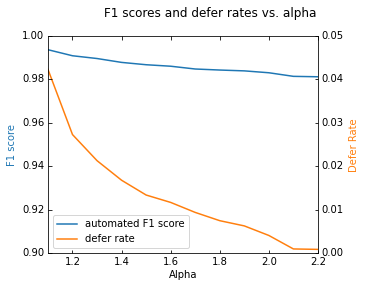

In [34]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

def plot_alpha_acc(x, y1, y2, title):
    fig = plt.figure()
    fig.suptitle(title, fontsize=12)
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()

    offset = 0
    new_fixed_axis = par1.get_grid_helper().new_fixed_axis
    par1.axis["right"] = new_fixed_axis(loc="right", axes=par1,
                                            offset=(offset, 0))

    par1.axis["right"].toggle(all=True)


    host.set_xlim(min(x), max(x))
    host.set_ylim(0.9, 1.0)

    host.set_xlabel("Alpha")
    host.set_ylabel("F1 score")
    par1.set_ylabel("Defer Rate")

    p1, = host.plot(x, y1, label="automated F1 score")
    p2, = par1.plot(x, y2, label="defer rate")
    # p2, = host.plot(x, y2, label="Overall F1 score")
    
    par1.set_ylim(0, 0.05)

    host.legend(loc="lower left")

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())

    plt.draw()
    plt.show()

    #plt.savefig("Test")

'Alpha', 'Deferred_Ratio', 'Deferred_Size', 'Auto_Size', \
                                         'Overall_F1', 'Overall_Recall', 'Overall_Precision', \
                                         'Auto_F1 (micro)', 'Auto_Recall (micro)', 'Auto_Precision (micro)'
x = ldu_scores['Alpha'].tolist()
y1 = ldu_scores['Auto_F1 (micro)'].tolist()
y2 = ldu_scores['Deferred_Ratio'].tolist()
# y2 = ldu_scores['Overall_F1'].tolist()



plot_alpha_acc(x, y1, y2, 'F1 scores and defer rates vs. alpha')
